In [747]:
import itertools
import scipy.interpolate
import numpy as np
from skimage import color
import os.path
import sys
import cv2
import dlib
import matplotlib.pyplot as plt
import re
import time
%matplotlib inline

height: 490 width 850


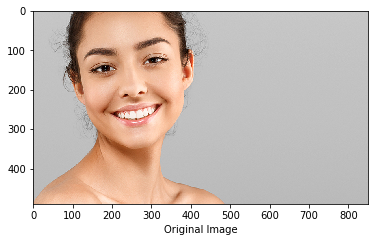

In [767]:
# read the image
r,g,b = (100,242,100)
ori = cv2.imread("face2.jpg")
img = ori.copy()
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.xlabel("Original Image")
plt.imshow(img)
height,width = img.shape[:2]
print("height:",height,"width",width)

111 52 379 320


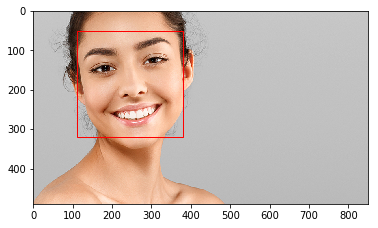

In [768]:
# face detection to get rect -> face landmark extract
PREDICTOR_PATH = "shape_predictor_68_face_landmarks.dat" # face landmark detector model path
CASC_PATH = "haarcascade_frontalface_default.xml"  # path to haar face detector model path

predictor = dlib.shape_predictor(PREDICTOR_PATH)
#cascade = cv2.CascadeClassifier(CASC_PATH)
detector = dlib.get_frontal_face_detector() # return a rectangle for face detection (left,right,top,bottom)

landmarks = []
try:
    rects = detector(img, 1)   # use 
    size = len(rects)
    if size == 0:
        print("No face found in the image")
    else:
        landmarks = np.matrix([[p.x, p.y] for p in predictor(img, rects[0]).parts()])
except Exception:
    print("Exception Occur")

    
index = re.sub("[\[\]\(\),]","",str(rects[0])).split()
index = [int(a) for a in index]
offset = index[2]-index[0]
plt.imshow(img)
print(index[0],index[1],index[2],index[3])
plt.gca().add_patch(plt.Rectangle((index[0],index[1]),offset,offset,linewidth=1,edgecolor='r',facecolor='none'))

In [769]:
# get lips points
lips = []
for point in landmarks[48:]:   # lips points start from no. 48 
    a,b = str(point).replace('[', '').replace(']', '').split()
    lips.append([int(a),int(b)])
    
# flatten the points
lips_points = [item for sublist in lips for item in sublist]

In [770]:
# Get the points that decribe Upper/Lower lips Upper/Lower bounds
uol = [] # sequential points of Upper Lips Upper bound left to right
uil = [] # sequential points of Lower Lips Lower bound right to left
lol = [] # sequential points of Upper lips Lower bound left to right
lil = [] # sequential points of Lower Lips Upper bound right to left

for i in range(0, 14, 2):  #point 49~55 Upper bound of upper lips
    uol.append([int(lips_points[i]), int(lips_points[i + 1])])

for i in range(12, 24, 2): #point 55~60 Lower bound of lower lips
    lol.append([int(lips_points[i]), int(lips_points[i + 1])])
lol.append([int(lips_points[0]), int(lips_points[1])]) # add the leftmost point back to balance the curve

for i in range(24, 34, 2): #point 61~65 Lower bound of Upper lips
    uil.append([int(lips_points[i]), int(lips_points[i + 1])])

for i in range(32, 40, 2): #point 65~68 Upper bound of Lower lips
    lil.append([int(lips_points[i]), int(lips_points[i + 1])])
lil.append([int(lips_points[24]), int(lips_points[25])]) # add the leftmost points(61) back to balance the curve

In [771]:
# Get the curve of lips with lips point by interpolation
#debug = 1
def __draw_curve(points,lips="upper"):
    """ Draws a curve alone the given points by creating an interpolated path. """
    x_pts = []
    y_pts = []
    curvex = []
    curvey = []
    debug = 3
    for point in points:
        x_pts.append(point[0])
        y_pts.append(point[1])
    curve = scipy.interpolate.interp1d(x_pts, y_pts, 'linear') # linear, quadraric, cubic approximation
    if lips=="upper":
        for i in np.arange(x_pts[0], x_pts[-1] + 1, 1):
            curvex.append(i)
            curvey.append(int(curve(i)))
    else:
        for i in np.arange(x_pts[len(x_pts) - 1] + 1, x_pts[0], 1):
            curvex.append(i)
            curvey.append(int(curve(i)))
    return curvex, curvey

uol_curve = __draw_curve(uol)
uil_curve = __draw_curve(uil)
lol_curve = __draw_curve(lol,"lower")
lil_curve = __draw_curve(lil,"lower")

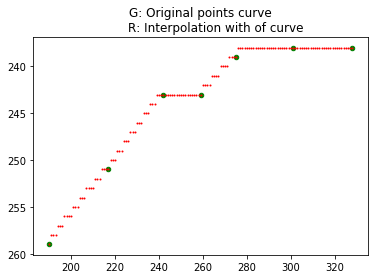

In [772]:
plt.scatter(np.array(uol)[:,0],np.array(uol)[:,1],20,color='g')
plt.scatter(uol_curve[0],uol_curve[1],1,color='r')
plt.gca().invert_yaxis()
plt.title("""G: Original points curve
        R: Interpolation with of curve""")
plt.show()

In [773]:
def fill_lip_lines(outer, inner):
        lip_x=[]
        lip_y=[]
        """ Fills the outlines of a lip with colour. """
        outer_curve = zip(outer[0], outer[1])
        inner_curve = zip(inner[0], inner[1])
        count = len(inner[0]) - 1
        last_inner = [inner[0][count], inner[1][count]]
        for o_point, i_point in itertools.zip_longest(
                outer_curve, inner_curve, fillvalue=last_inner
            ):
            line = scipy.interpolate.interp1d(
                [o_point[0], i_point[0]], [o_point[1], i_point[1]], 'linear')
            xpoints = list(np.arange(o_point[0], i_point[0], 1))
            lip_x.extend(xpoints)
            lip_y.extend([int(point) for point in line(xpoints)])
        return lip_x, lip_y

In [774]:
def add_color(image,intensity,lip_x,lip_y,r,g,b):
        """ Adds base colour to all points on lips, at mentioned intensity. """
        red_l = float(r)
        green_l = float(g)
        blue_l = float(b)
        
        val = color.rgb2lab(
            (image[lip_y, lip_x] / 255.)
            .reshape(len(lip_y), 1, 3)
        ).reshape(len(lip_y), 3)
        l_val, a_val, b_val = np.mean(val[:, 0]), np.mean(val[:, 1]), np.mean(val[:, 2])
        l1_val, a1_val, b1_val = color.rgb2lab(
            np.array(
                (red_l / 255., green_l / 255., blue_l / 255.)
                ).reshape(1, 1, 3)
            ).reshape(3,)
        l_final, a_final, b_final = (l1_val - l_val) * \
            intensity, (a1_val - a_val) * \
            intensity, (b1_val - b_val) * intensity
        val[:, 0] = np.clip(val[:, 0] + l_final, 0, 100)
        val[:, 1] = np.clip(val[:, 1] + a_final, -127, 128)
        val[:, 2] = np.clip(val[:, 2] + b_final, -127, 128)
        image[lip_y, lip_x] = color.lab2rgb(val.reshape(
            len(lip_y), 1, 3)).reshape(len(lip_y), 3) * 255
        return image

In [775]:
lx1,ly1 = fill_lip_lines(uol_curve,uil_curve)
lx2,ly2 = fill_lip_lines(lol_curve,lil_curve)

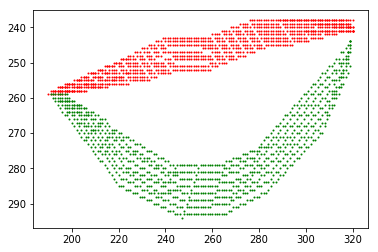

In [776]:
plt.scatter(lx1,ly1,1,color='r')
plt.scatter(lx2,ly2,1,color='g')
plt.gca().invert_yaxis() # reverse axis as the image
plt.show()

In [777]:
new_img = add_color(img.copy(),0.5,lx1+lx2,ly1+ly2,r,g,b)

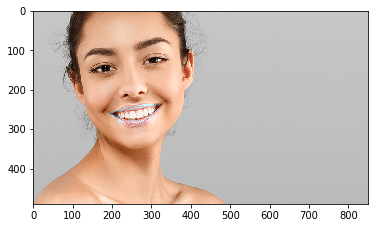

In [778]:
plt.imshow(new_img)

In [779]:
def fill_lip_solid(image,outer, inner,rgb=(r,g,b)):
        """ Fills solid colour inside two outlines. """
        red_l,green_l,blue_l = rgb
        inner[0].reverse()
        inner[1].reverse()
        outer_curve = zip(outer[0], outer[1])
        inner_curve = zip(inner[0], inner[1])
        points = []
        for point in outer_curve:
            points.append(np.array(point, dtype=np.int32))
        for point in inner_curve:
            points.append(np.array(point, dtype=np.int32))
        points = np.array(points, dtype=np.int32)
        red_l = int(red_l)
        green_l = int(green_l)
        blue_l = int(blue_l)
        cv2.fillPoly(image, [points], (red_l, green_l, blue_l))
        return image

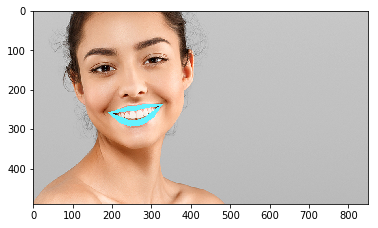

In [780]:
new_img = fill_lip_solid(img.copy(),uol_curve,uil_curve)
new_img = fill_lip_solid(new_img,lol_curve,lil_curve)
plt.imshow(new_img)
plt.show()

In [781]:
def smoothen_color(outer, inner,image,im_copy):
        """ Smoothens and blends colour applied between a set of outlines. """
        
        height = image.shape[0]
        width = image.shape[1]
        outer_curve = zip(outer[0], outer[1])
        inner_curve = zip(inner[0], inner[1])
        x_points = []
        y_points = []
        for point in outer_curve:
            x_points.append(point[0])
            y_points.append(point[1])
        for point in inner_curve:
            x_points.append(point[0])
            y_points.append(point[1])
        img_base = np.zeros((height, width))
        cv2.fillConvexPoly(img_base, np.array(np.c_[x_points, y_points], dtype='int32'), 1)
        
        img_mask = cv2.GaussianBlur(img_base, (81, 81), 0) #51,51
        img_blur_3d = np.ndarray([height, width, 3], dtype='float')
        img_blur_3d[:, :, 0] = img_mask
        img_blur_3d[:, :, 1] = img_mask
        img_blur_3d[:, :, 2] = img_mask
        
        
        #kernel = np.ones((12,12),np.uint8)
        #img_blur_3d = cv2.erode(img_blur_3d,kernel,iterations = 1)
        
        im_copy = (img_blur_3d * image * 0.7 + (1 - img_blur_3d * 0.7) * im_copy).astype('uint8')
        return im_copy

In [782]:
a = smoothen_color(uol_curve,uil_curve,new_img,img) # smooth the upper lips
b = smoothen_color(lol_curve,lil_curve,new_img,a)   # smooth the lower lips

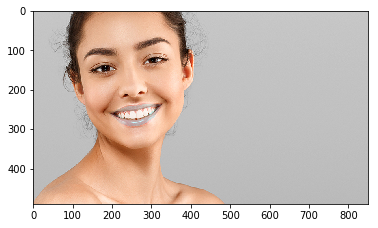

In [783]:
plt.imshow(b)

In [784]:
timestr = time.strftime("%Y%m%d-%H%M%S")
b = cv2.cvtColor(b, cv2.COLOR_BGR2RGB)
cv2.imwrite(timestr+'.png', b)

True

In [485]:
def addVRLipstick(filepath,rgb = (0,0.,255)):
    r,g,b = rgb
    ori = cv2.imread(filepath)
    img = ori.copy()
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    height,width = img.shape[:2]
    #print("height:",height,"width",width)
    PREDICTOR_PATH = "shape_predictor_68_face_landmarks.dat" # face landmark detector model path
    CASC_PATH = "haarcascade_frontalface_default.xml"  # path to haar face detector model path

    predictor = dlib.shape_predictor(PREDICTOR_PATH)
    #cascade = cv2.CascadeClassifier(CASC_PATH)
    detector = dlib.get_frontal_face_detector() # return a rectangle for face detection (left,right,top,bottom)

    landmarks = []
    try:
        rects = detector(img, 1)   # use 
        size = len(rects)
        if size == 0:
            print("No face found in the image")
        else:
            landmarks = np.matrix([[p.x, p.y] for p in predictor(img, rects[0]).parts()])
    except Exception:
        print("Exception Occur")
        
        
    # get lips points
    lips = []
    for point in landmarks[48:]:   # lips points start from no. 48 
        a,b = str(point).replace('[', '').replace(']', '').split()
        lips.append([int(a),int(b)])

    # flatten the points
    lips_points = [item for sublist in lips for item in sublist]
    
    # Get the points that decribe Upper/Lower lips Upper/Lower bounds
    uol = [] # sequential points of Upper Lips Upper bound left to right
    uil = [] # sequential points of Lower Lips Lower bound right to left
    lol = [] # sequential points of Upper lips Lower bound left to right
    lil = [] # sequential points of Lower Lips Upper bound right to left

    for i in range(0, 14, 2):  #point 49~55 Upper bound of upper lips
        uol.append([int(lips_points[i]), int(lips_points[i + 1])])

    for i in range(12, 24, 2): #point 55~60 Lower bound of lower lips
        lol.append([int(lips_points[i]), int(lips_points[i + 1])])
    lol.append([int(lips_points[0]), int(lips_points[1])]) # add the leftmost point back to balance the curve

    for i in range(24, 34, 2): #point 61~65 Lower bound of Upper lips
        uil.append([int(lips_points[i]), int(lips_points[i + 1])])

    for i in range(32, 40, 2): #point 65~68 Upper bound of Lower lips
        lil.append([int(lips_points[i]), int(lips_points[i + 1])])
    lil.append([int(lips_points[24]), int(lips_points[25])]) # add the leftmost points(61) back to balance the curve
    
    uol_curve = __draw_curve(uol)
    uil_curve = __draw_curve(uil)
    lol_curve = __draw_curve(lol,"lower")
    lil_curve = __draw_curve(lil,"lower")
    
    lx1,ly1 = fill_lip_lines(uol_curve,uil_curve)
    lx2,ly2 = fill_lip_lines(lol_curve,lil_curve)
    
    new_img = add_color(img.copy(),1,lx1+lx2,ly1+ly2,r,g,b)
    
    new_img = fill_lip_solid(img.copy(),uol_curve,uil_curve,(r,g,b))
    new_img = fill_lip_solid(new_img,lol_curve,lil_curve,(r,g,b))
    
    a = smoothen_color(uol_curve,uil_curve,new_img,img) # smooth the upper lips
    b = smoothen_color(lol_curve,lil_curve,new_img,a)   # smooth the lower lips
    
    timestr = time.strftime("%Y%m%d-%H%M%S")
    timestr = time.strftime("%Y%m%d-%H%M%S")
    b = cv2.cvtColor(b, cv2.COLOR_BGR2RGB)
    cv2.imwrite(timestr+'.png', b)
    

In [486]:
addVRLipstick("face3.jpg")